In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import umap
import kmapper as km
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV

In [2]:
e21 = pd.read_excel("Edenred 2021.xlsx",  engine="openpyxl")
e22 = pd.read_excel("Edenred 2022.xlsx", engine="openpyxl")
e23 = pd.read_excel("Edenred 2023.xlsx", engine="openpyxl")
e24 = pd.read_excel("Edenred 2024.xlsx", engine="openpyxl")

In [3]:
#  limpieza
def limpiar_edenred(df, año):
    df.columns = df.columns.str.strip().str.replace("  ", " ").str.replace(" ", "_").str.lower()
    df["año"] = año
    posibles_fechas = [col for col in df.columns if "fecha" in col or "transaccion" in col]
    if posibles_fechas:
        df["fecha"] = pd.to_datetime(df[posibles_fechas[0]], errors="coerce", dayfirst=True)
    df = df.dropna(axis=1, how='all')
    df = df.drop_duplicates()
    posibles_conceptos = [col for col in df.columns if "concepto" in col or "tipo" in col]
    if posibles_conceptos:
        df = df[~df[posibles_conceptos[0]].str.contains("bonif|ajuste|admin", case=False, na=False)]
    return df

In [4]:
# unir
e21_clean = limpiar_edenred(e21, 2021)
e22_clean = limpiar_edenred(e22, 2022)
e23_clean = limpiar_edenred(e23, 2023)
e24_clean = limpiar_edenred(e24, 2024)

df_edenred = pd.concat([e21_clean, e22_clean, e23_clean, e24_clean], ignore_index=True)

# Filtrar columnas con <= 30% de nulos
umbral_nulos = 0.3
porcentaje_nulos = df_edenred.isnull().mean()
columnas_validas = porcentaje_nulos[porcentaje_nulos <= umbral_nulos].index.tolist()
df_filtrado = df_edenred[columnas_validas].copy()

In [5]:
df_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39850 entries, 0 to 39849
Data columns (total 46 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   month                   39833 non-null  object        
 1   id_grupo_región         39833 non-null  object        
 2   cliente                 39833 non-null  object        
 3   factura                 39833 non-null  object        
 4   id_región               39833 non-null  object        
 5   serie                   39833 non-null  object        
 6   division                39833 non-null  object        
 7   bl                      39833 non-null  object        
 8   sub_bl                  39833 non-null  object        
 9   identificador_vehículo  39833 non-null  object        
 10  vehículo                39833 non-null  object        
 11  placa                   39833 non-null  object        
 12  num_tarjeta             39833 non-null  float6

In [6]:
df_filtrado["Unidad"] = df_filtrado.apply(
    lambda row: row["vehículo"].replace(
        row["identificador_vehículo"].replace(" ", ""), ""
    ).replace(" ", "").upper().strip()
    if isinstance(row["vehículo"], str) and isinstance(row["identificador_vehículo"], str)
    else "SIN_DATO",
    axis=1
)

In [7]:
df_filtrado["Unidad"].nunique()

253

In [8]:
df_filtrado.columns


Index(['month', 'id_grupo_región', 'cliente', 'factura', 'id_región', 'serie',
       'division', 'bl', 'sub_bl', 'identificador_vehículo', 'vehículo',
       'placa', 'num_tarjeta', 'num_serie', 'fecha_transacción',
       'hora_transacción', 'no_comprobante', 'id_mercancía', 'mercancía',
       'km_ant_transacción', 'km_transacción', 'recorrido', 'importe_neto',
       'iva_%', 'ieps', 'importe_transacción', 'comision', 'subtotal',
       'cantidad_mercancía', 'kg_c02', 'ton_c02', 'arboles', 'precio_unitario',
       'rendimiento', 'rendimiento_real', 'id_conductor', 'conductor',
       'no_estación_pemex', 'razón_social_afiliado', 'rfc',
       'número_de_control', 'folio', 'observación', 'respuesta', 'año',
       'fecha', 'Unidad'],
      dtype='object')

In [9]:
df_filtrado=df_filtrado.sort_index()

In [10]:
print(df_filtrado["Unidad"].isnull().sum())  
print((df_filtrado["Unidad"] == "").sum())  

0
0


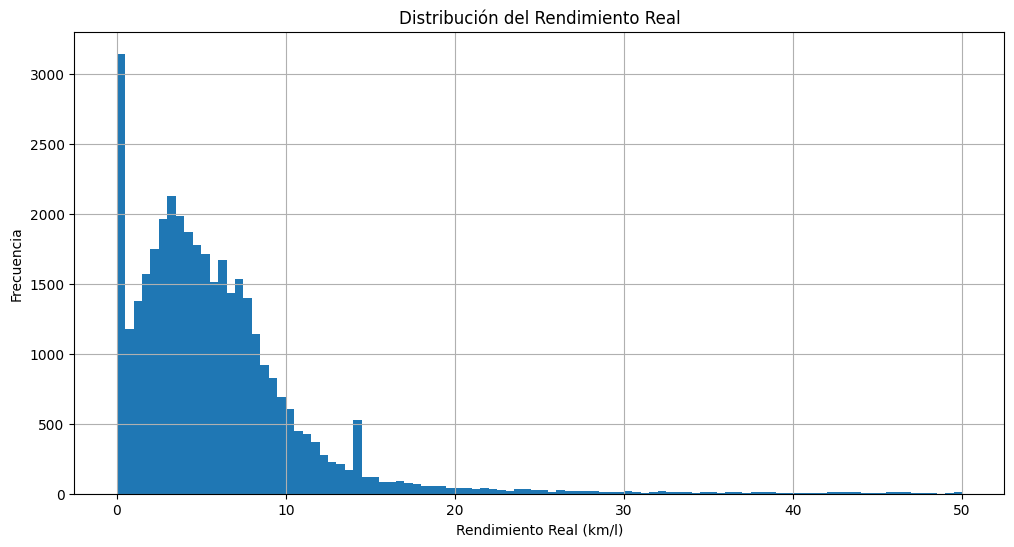

In [11]:
# Convertir la columna de rendimiento a numérica 
df_filtrado["rendimiento_real"] = pd.to_numeric(df_filtrado["rendimiento_real"], errors="coerce")

plt.figure(figsize=(12, 6))
df_filtrado["rendimiento_real"].hist(bins=100, range=(0, 50))
plt.title("Distribución del Rendimiento Real")
plt.xlabel("Rendimiento Real (km/l)")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

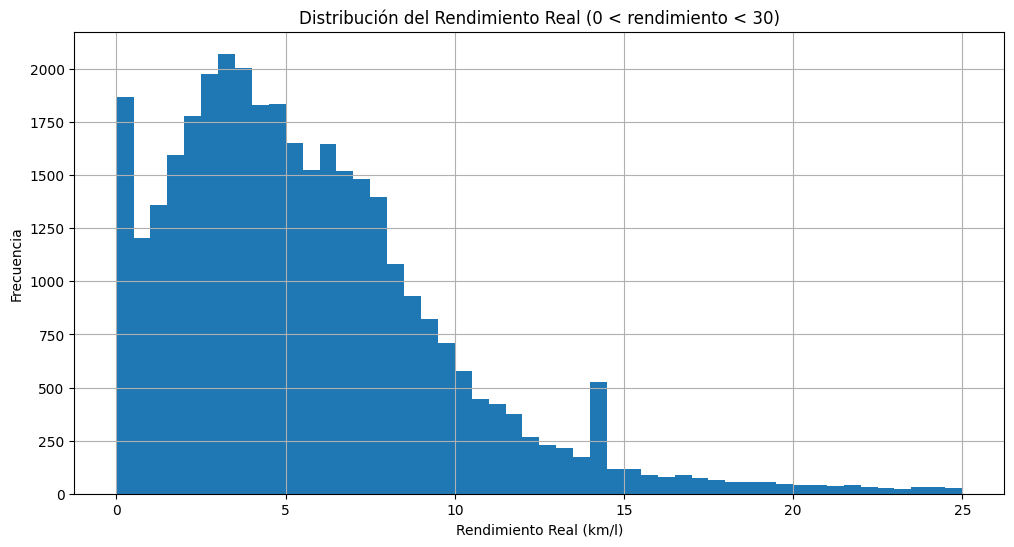

In [12]:
df_filtrado = df_filtrado[(df_filtrado["rendimiento_real"] > 0) & (df_filtrado["rendimiento_real"] < 25)].copy()

plt.figure(figsize=(12, 6))
df_filtrado["rendimiento_real"].hist(bins=50) 
plt.title("Distribución del Rendimiento Real (0 < rendimiento < 30)")
plt.xlabel("Rendimiento Real (km/l)")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

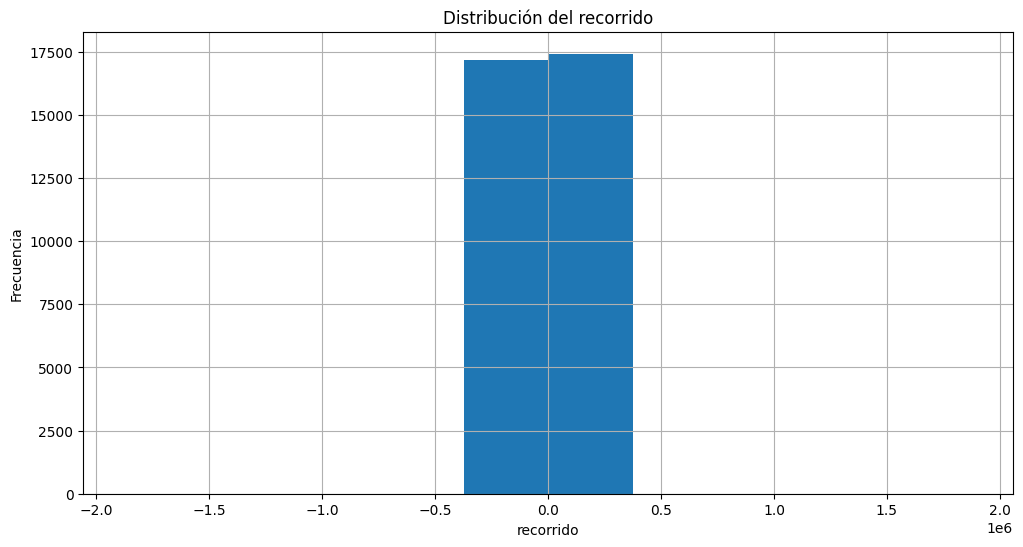

In [13]:
import matplotlib.pyplot as plt

df_filtrado["recorrido"] = pd.to_numeric(df_filtrado["recorrido"])

plt.figure(figsize=(12, 6))
df_filtrado["recorrido"].hist()
plt.title("Distribución del recorrido")
plt.xlabel("recorrido")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

In [14]:
# Definir columnas relevantes
columnas_finales = [
    "recorrido",
    "precio_unitario",
    "cantidad_mercancía",
    "rendimiento",
    "rendimiento_real"
]

# Contar cuántos valores NO nulos tiene cada una
df_filtrado[columnas_finales].count().sort_values()


recorrido             34597
precio_unitario       34704
cantidad_mercancía    34704
rendimiento           34704
rendimiento_real      34704
dtype: int64

In [15]:
# Eliminar recorridos negativos o cero
df_filtrado = df_filtrado[df_filtrado['recorrido'] > 0]

# Calcular percentiles para detectar outliers
q1 = df_filtrado['recorrido'].quantile(0.01)
q99 = df_filtrado['recorrido'].quantile(0.99)

# Filtrar valores extremos
df_filtrado = df_filtrado[(df_filtrado['recorrido'] >= q1) & (df_filtrado['recorrido'] <= q99)]


In [16]:
df_filtrado['recorrido'].describe()

count    34224.000000
mean       316.808439
std        217.713786
min          1.000000
25%        173.000000
50%        282.000000
75%        414.000000
max       1764.000000
Name: recorrido, dtype: float64

In [17]:
df_filtrado=df_filtrado.sort_index()

## Análisis de persistencia y homología

In [18]:
%pip install ripser persim


Note: you may need to restart the kernel to use updated packages.


In [19]:
from ripser import ripser
from persim import wasserstein
from itertools import combinations
from scipy.stats import pearsonr

### Diagrama de persistencia

In [20]:
# Contar cuántas transacciones tiene cada unidad
conteos = df_filtrado["Unidad"].value_counts()

# Filtrar las que tienen al menos 100 transacciones
unidades_validas = conteos[conteos >= 100].index.tolist()

# Crear nuevo DataFrame solo con esas unidades
df_filtrado_mas100 = df_filtrado[df_filtrado["Unidad"].isin(unidades_validas)]





In [21]:
# Variables que definen el "comportamiento" de la unidad
features = ["recorrido", "precio_unitario", "cantidad_mercancía"]

resultados = []

# Analizar cada unidad por separado
for unidad, grupo in df_filtrado_mas100.groupby("Unidad"):
    datos = grupo[features].dropna()
    if len(datos) < 5:
        continue
    X = StandardScaler().fit_transform(datos)

    # Calcular homología H0 (componentes conexas)
    dgm = ripser(X, maxdim=1)["dgms"][0]

    # Métricas topológicas
    suma_persistencias = sum([b[1] - b[0] for b in dgm if b[1] < float("inf")])
    num_componentes = len(dgm)
    max_persistencia = max([b[1] - b[0] for b in dgm if b[1] < float("inf")], default=0)

    # Promedio de rendimiento real
    rendimiento_real = grupo["rendimiento_real"].mean()

    # Guardar resultados
    resultados.append({
        "Unidad": unidad,
        "Rendimiento": rendimiento_real,
        "Suma_Persistencias_H0": suma_persistencias,
        "Num_Componentes_H0": num_componentes,
        "Max_Persistencia_H0": max_persistencia
    })


In [22]:
# Convertir los resultados en un DataFrame
df_topologia = pd.DataFrame(resultados)

# Mostrar las primeras filas para revisar
df_topologia.head()


,Unidad,Rendimiento,Suma_Persistencias_H0,Num_Componentes_H0,Max_Persistencia_H0
0,UNIDAD1FBAX,5.075999,289.270824,2413,10.499494
1,UNIDAD1FDAF,6.048194,89.142161,299,9.753056
2,UNIDAD1FDEF,4.058621,104.268837,290,4.457669
3,UNIDAD1FDRF,4.598900,52.205821,100,2.854676
4,UNIDAD1FDWF,3.545426,169.860649,836,2.029956


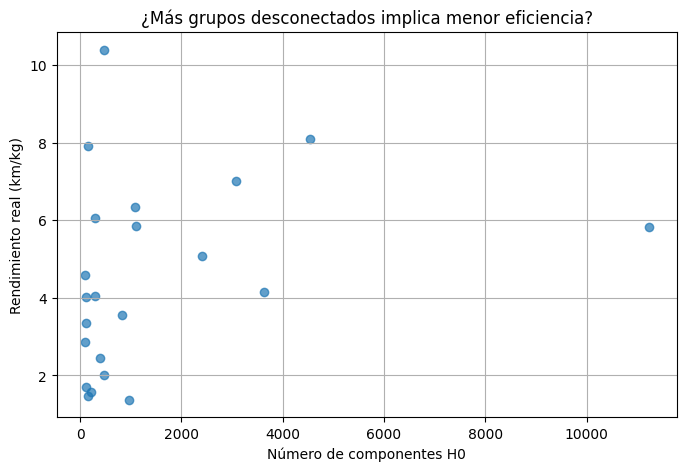

In [23]:
plt.figure(figsize=(8, 5))
plt.scatter(df_topologia["Num_Componentes_H0"], df_topologia["Rendimiento"], alpha=0.7)
plt.xlabel("Número de componentes H0")
plt.ylabel("Rendimiento real (km/kg)")
plt.title("¿Más grupos desconectados implica menor eficiencia?")
plt.grid(True)
plt.show()


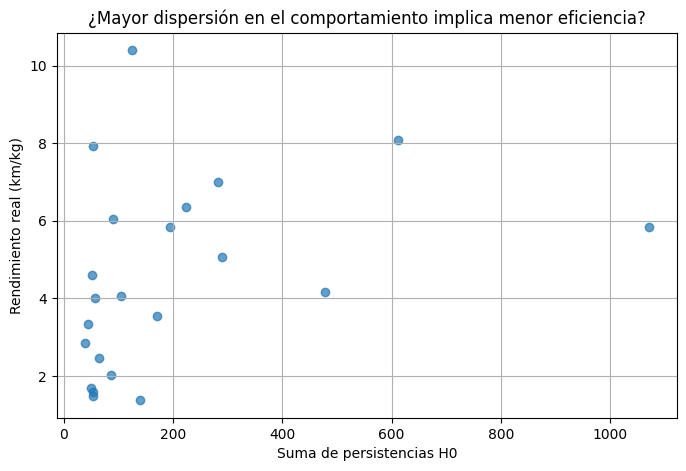

In [24]:
plt.figure(figsize=(8, 5))
plt.scatter(df_topologia["Suma_Persistencias_H0"], df_topologia["Rendimiento"], alpha=0.7)
plt.xlabel("Suma de persistencias H0")
plt.ylabel("Rendimiento real (km/kg)")
plt.title("¿Mayor dispersión en el comportamiento implica menor eficiencia?")
plt.grid(True)
plt.show()


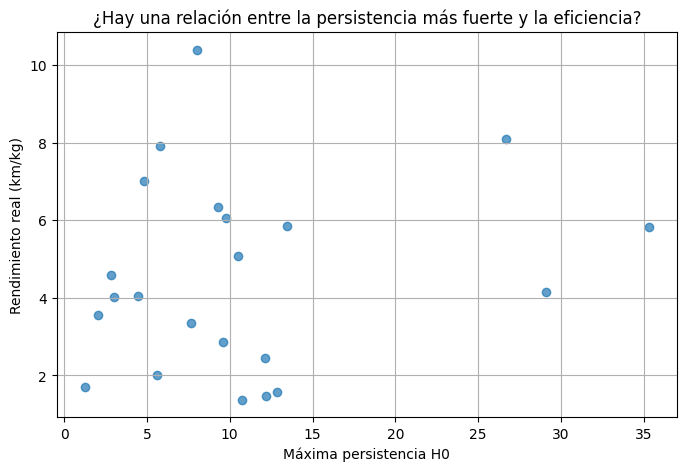

In [25]:
plt.figure(figsize=(8, 5))
plt.scatter(df_topologia["Max_Persistencia_H0"], df_topologia["Rendimiento"], alpha=0.7)
plt.xlabel("Máxima persistencia H0")
plt.ylabel("Rendimiento real (km/kg)")
plt.title("¿Hay una relación entre la persistencia más fuerte y la eficiencia?")
plt.grid(True)
plt.show()


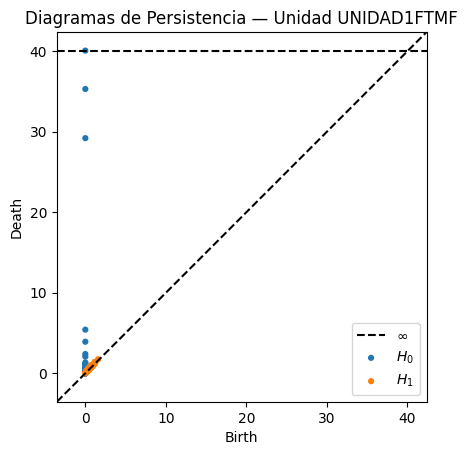

In [26]:
from persim import plot_diagrams
from ripser import ripser
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Elegir una unidad con más de 100 registros
unidad_ejemplo = df_filtrado_mas100["Unidad"].value_counts().idxmax()
grupo_ejemplo = df_filtrado_mas100[df_filtrado_mas100["Unidad"] == unidad_ejemplo]

# Seleccionar y normalizar las variables operativas
datos = grupo_ejemplo[["recorrido", "precio_unitario", "cantidad_mercancía"]].dropna()
X = StandardScaler().fit_transform(datos)

# Calcular diagrama de persistencia
dgms = ripser(X, maxdim=1)["dgms"]

# Graficar H0 y H1
plot_diagrams(dgms, show=True, title=f"Diagramas de Persistencia — Unidad {unidad_ejemplo}")


## Segundo Análisis

In [27]:
df_filtrado1 = df_filtrado.copy()

In [28]:
# Mapeo de nombres a números
meses_es = {
    "Ene": "01", "Feb": "02", "Mar": "03", "Abr": "04",
    "May": "05", "Jun": "06", "Jul": "07", "Ago": "08",
    "Sep": "09", "Oct": "10", "Nov": "11", "Dic": "12"
}

# Reemplazar en la columna 'mes'
df_filtrado1["mes_num"] = df_filtrado1["month"].map(meses_es)

# Crear columna 'Mes' en formato año-mes (ej. 2022-04)
df_filtrado1["month"] = df_filtrado1["año"].astype(str) + "-" + df_filtrado1["mes_num"]
df_filtrado1["month"] = pd.to_datetime(df_filtrado1["month"]).dt.to_period("M")

In [29]:
unidad_ejemplo = df_filtrado1["identificador_vehículo"].value_counts().idxmax()
grupo_unidad = df_filtrado1[df_filtrado1["identificador_vehículo"] == unidad_ejemplo].copy()


In [ ]:
import ripser
from sklearn.preprocessing import StandardScaler

In [31]:

features = ["recorrido", "precio_unitario", "cantidad_mercancía"]  
resultados_mensuales = []

for mes, grupo in grupo_unidad.groupby("month"):
    datos = grupo[features].dropna()
    if len(datos) < 5:
        continue

    X = StandardScaler().fit_transform(datos)
    dgm = ripser(X, maxdim=1)["dgms"][0] 

    suma_persistencias = sum(b[1] - b[0] for b in dgm if b[1] < float("inf"))
    num_componentes = len(dgm)
    max_persistencia = max([b[1] - b[0] for b in dgm if b[1] < float("inf")], default=0)
    rendimiento = grupo["rendimiento_real"].mean()

    resultados_mensuales.append({
        "Mes": str(mes),
        "Rendimiento": rendimiento,
        "Suma_Persistencias_H0": suma_persistencias,
        "Num_Componentes_H0": num_componentes,
        "Max_Persistencia_H0": max_persistencia
    })

df_mensual = pd.DataFrame(resultados_mensuales).sort_values("Mes").reset_index(drop=True)


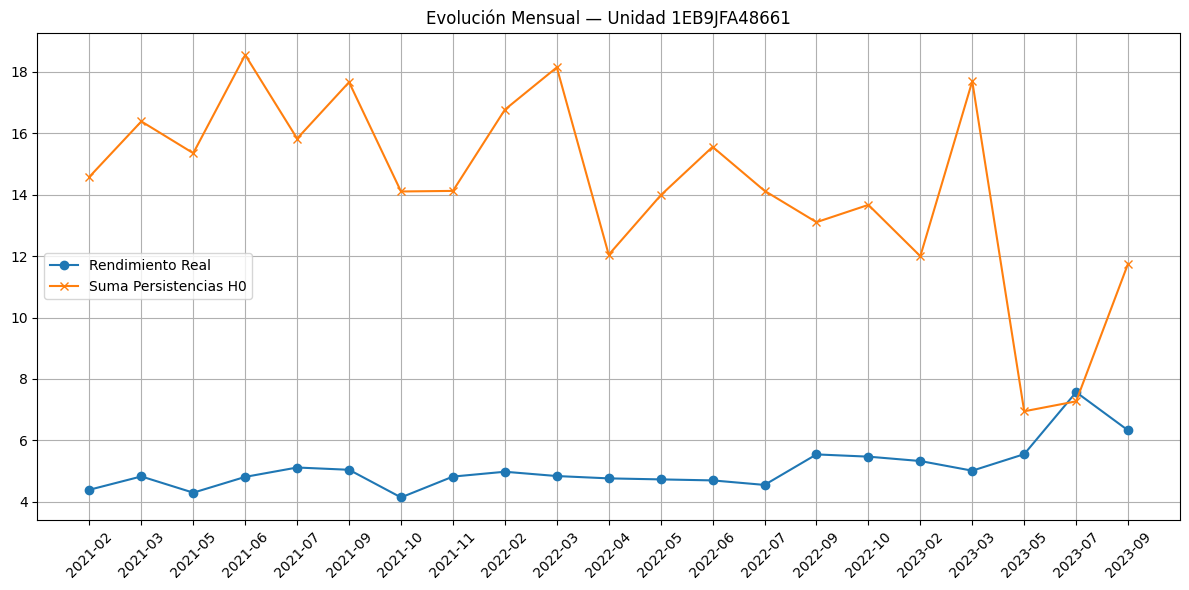

In [32]:


plt.figure(figsize=(12,6))
plt.plot(df_mensual["Mes"], df_mensual["Rendimiento"], label="Rendimiento Real", marker="o")
plt.plot(df_mensual["Mes"], df_mensual["Suma_Persistencias_H0"], label="Suma Persistencias H0", marker="x")
plt.xticks(rotation=45)
plt.title(f"Evolución Mensual — Unidad {unidad_ejemplo}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Distancias de Wassertein de Rendimiento Real

In [71]:

df_sorted = df_filtrado1.sort_values("month").reset_index(drop=True)

df_rend = df_sorted[df_sorted["rendimiento_real"].notna()].reset_index(drop=True)

rendimientos = df_rend["rendimiento_real"].values
fechas = df_rend["month"]

In [72]:
import numpy as np

def embed_time_series(time_series, delay, dim):
    n = len(time_series)
    embedded_data = np.zeros((n - (dim - 1) * delay, dim))

    for i in range(dim):
        embedded_data[:, i] = time_series[i * delay : n - (dim - 1) * delay + i * delay]

    return embedded_data

# Parámetros de embedding
window_size = 50
delay = 2
dim = 3


In [73]:
from ripser import ripser
from persim import wasserstein
from tqdm import tqdm

diagrams = []
window_fechas = []

# Recorrer ventanas móviles sobre la serie
for i in tqdm(range(len(rendimientos) - window_size + 1)):
    ventana = rendimientos[i : i + window_size]
    emb = embed_time_series(ventana, delay, dim)
    dgm = ripser(emb)["dgms"]
    diagrams.append(dgm)
    
    # Fecha del centro de la ventana
    window_fechas.append(fechas[i + window_size // 2])


100%|██████████| 34175/34175 [00:35<00:00, 966.42it/s] 


In [74]:
# Referencia: diagrama H1 de la primera ventana
ref = diagrams[0]

# Distancias de Wasserstein (H1: ciclos)
wasserstein_distances = []

for dgm in diagrams:
    if len(dgm) > 1 and len(ref) > 1:
        dist = wasserstein(ref[1], dgm[1])
    else:
        dist = 0  # Si no hay H1, poner 0
    wasserstein_distances.append(dist)


C:\Users\Karla Cantu\AppData\Local\Temp\ipykernel_23456\2881470115.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_mensual = df_plot.resample("M", on="Fecha").mean().dropna()
C:\Users\Karla Cantu\AppData\Local\Temp\ipykernel_23456\2881470115.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_wasserstein_mensual = df_wasserstein.resample("M", on="Fecha").mean().dropna()


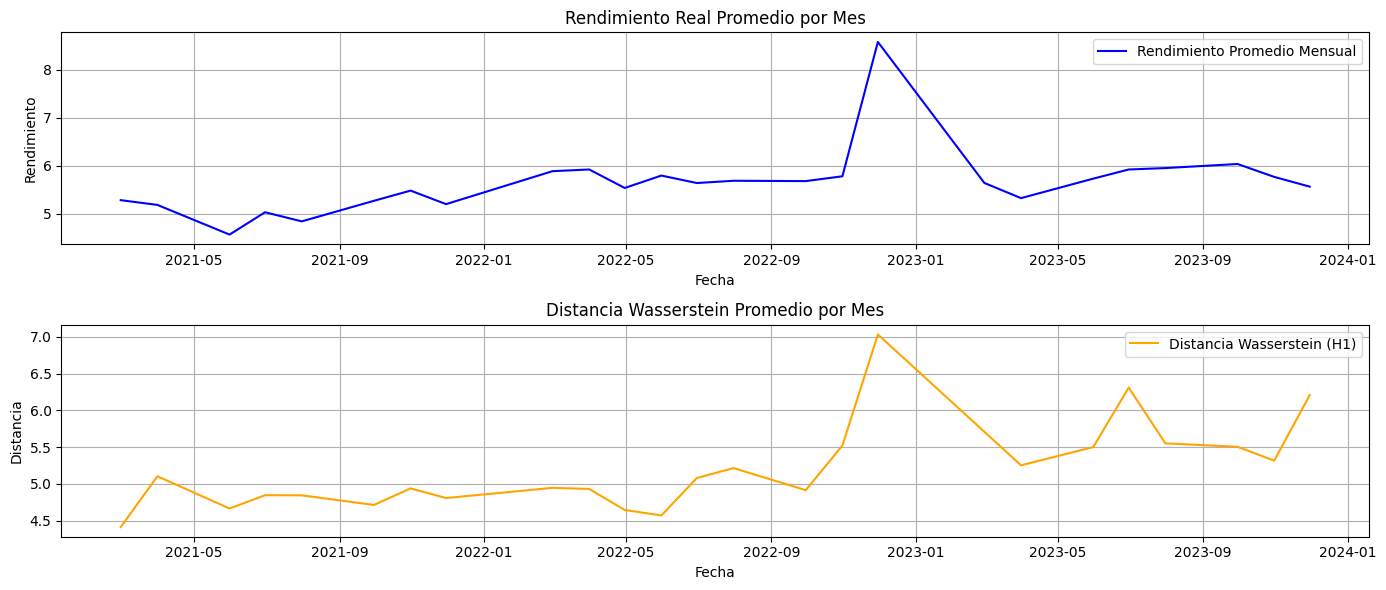

In [84]:
import matplotlib.pyplot as plt
from persim import plot_diagrams
import pandas as pd

# Convertir fechas a datetime y armar DataFrame sincronizado
fechas_clean = pd.Series(fechas).dropna().apply(lambda x: x.to_timestamp())
rendimientos_clean = rendimientos[:len(fechas_clean)]

df_plot = pd.DataFrame({
    "Fecha": fechas_clean.reset_index(drop=True),
    "Rendimiento": rendimientos_clean
})

# Agrupar por mes (usar primer día de cada mes como referencia)
df_mensual = df_plot.resample("M", on="Fecha").mean().dropna()

# Crear DataFrame para distancias
df_wasserstein = pd.DataFrame({
    "Fecha": window_fechas_plot.values,
    "Distancia": wasserstein_distances[:min_len]
})

# Agrupar por mes
df_wasserstein_mensual = df_wasserstein.resample("M", on="Fecha").mean().dropna()

# ----- GRAFICAR -----
plt.figure(figsize=(14, 6))

# Gráfico 1: Rendimiento promedio mensual
plt.subplot(2, 1, 1)
plt.plot(df_mensual.index, df_mensual["Rendimiento"], label="Rendimiento Promedio Mensual", color="blue")
plt.title("Rendimiento Real Promedio por Mes")
plt.xlabel("Fecha")
plt.ylabel("Rendimiento")
plt.grid(True)
plt.legend()

# Gráfico 2: Distancia Wasserstein
plt.subplot(2, 1, 2)
plt.plot(df_wasserstein_mensual.index, df_wasserstein_mensual["Distancia"], label="Distancia Wasserstein (H1)", color="orange")
plt.title("Distancia Wasserstein Promedio por Mes")
plt.xlabel("Fecha")
plt.ylabel("Distancia")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


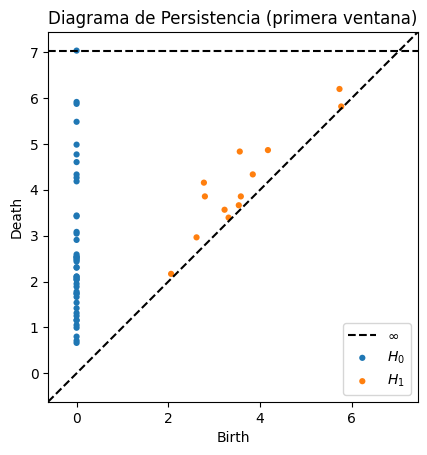

In [76]:
from persim import plot_diagrams
import matplotlib.pyplot as plt

# Mostrar el primer diagrama de persistencia (índice 0)
if diagrams and diagrams[0]:  # asegurarse de que no esté vacío
    plot_diagrams(diagrams[0], show=True, title="Diagrama de Persistencia (primera ventana)")
else:
    print("No hay diagramas disponibles.")


## KG de CO2 distancias

In [86]:

df_sorted2 = df_filtrado1.sort_values("month").reset_index(drop=True)

df_rend2 = df_sorted2[df_sorted2["kg_c02"].notna()].reset_index(drop=True)

co2 = df_rend2["kg_c02"].values
fechas2 = df_rend2["month"]

In [87]:
from ripser import ripser
from persim import wasserstein
from tqdm import tqdm

diagrams2 = []
window_fechas2 = []

# Recorrer ventanas móviles sobre la serie
for i in tqdm(range(len(co2) - window_size + 1)):
    ventana2 = co2[i : i + window_size]
    emb2 = embed_time_series(ventana2, delay, dim)
    dgm2 = ripser(emb2)["dgms"]
    diagrams2.append(dgm2)
    
    # Fecha del centro de la ventana
    window_fechas2.append(fechas2[i + window_size // 2])


100%|██████████| 33886/33886 [00:34<00:00, 968.63it/s] 


In [88]:
# Referencia: diagrama H1 de la primera ventana
ref2 = diagrams2[0]

# Distancias de Wasserstein (H1: ciclos)
wasserstein_distances2 = []

for dgm2 in diagrams2:
    if len(dgm2) > 1 and len(ref2) > 1:
        dist2 = wasserstein(ref2[1], dgm2[1])
    else:
        dist2 = 0  # Si no hay H1, poner 0
    wasserstein_distances2.append(dist2)


C:\Users\Karla Cantu\AppData\Local\Temp\ipykernel_23456\2280088630.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_mensual2 = df_plot2.resample("M", on="Fecha3").mean().dropna()
C:\Users\Karla Cantu\AppData\Local\Temp\ipykernel_23456\2280088630.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_wasserstein_mensual2 = df_wasserstein2.resample("M", on="Fecha4").mean().dropna()


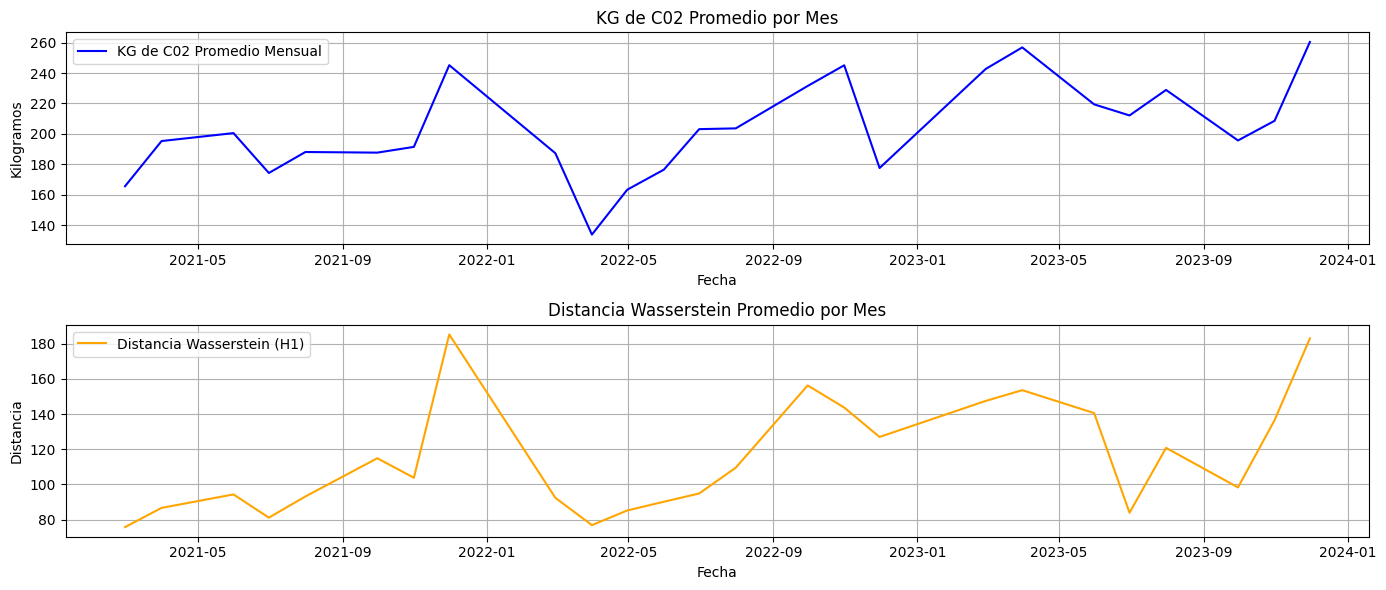

In [89]:
import matplotlib.pyplot as plt
from persim import plot_diagrams
import pandas as pd

# Convertir fechas a datetime y armar DataFrame sincronizado
fechas_clean2 = pd.Series(fechas2).dropna().apply(lambda x: x.to_timestamp())
co2_clean2= co2[:len(fechas_clean2)]

df_plot2 = pd.DataFrame({
    "Fecha3": fechas_clean2.reset_index(drop=True),
    "CO2": co2_clean2
})

# Agrupar por mes (usar primer día de cada mes como referencia)
df_mensual2 = df_plot2.resample("M", on="Fecha3").mean().dropna()

# Crear DataFrame para distancias
df_wasserstein2 = pd.DataFrame({
    "Fecha4": window_fechas_plot[:min_len].values,
    "Distancia4": wasserstein_distances2[:min_len]
})

# Agrupar por mes
df_wasserstein_mensual2 = df_wasserstein2.resample("M", on="Fecha4").mean().dropna()

# ----- GRAFICAR -----
plt.figure(figsize=(14, 6))

# Gráfico 1: Rendimiento promedio mensual
plt.subplot(2, 1, 1)
plt.plot(df_mensual2.index, df_mensual2["CO2"], label="KG de C02 Promedio Mensual", color="blue")
plt.title("KG de C02 Promedio por Mes")
plt.xlabel("Fecha")
plt.ylabel("Kilogramos")
plt.grid(True)
plt.legend()

# Gráfico 2: Distancia Wasserstein
plt.subplot(2, 1, 2)
plt.plot(df_wasserstein_mensual2.index, df_wasserstein_mensual2["Distancia4"], label="Distancia Wasserstein (H1)", color="orange")
plt.title("Distancia Wasserstein Promedio por Mes")
plt.xlabel("Fecha")
plt.ylabel("Distancia")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


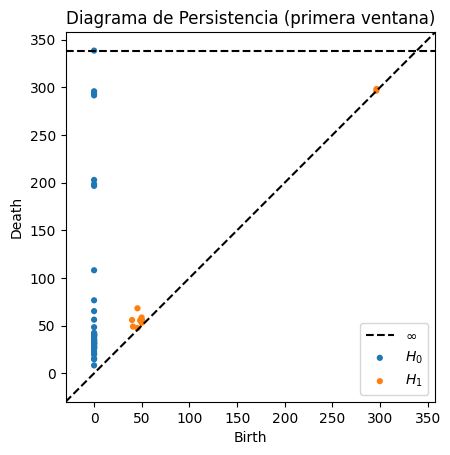

In [99]:
from persim import plot_diagrams
import matplotlib.pyplot as plt

# Mostrar el primer diagrama de persistencia (índice 0)
if diagrams2 and diagrams2[0]:  # asegurarse de que no esté vacío
    plot_diagrams(diagrams2[0], show=True, title="Diagrama de Persistencia (primera ventana)")
else:
    print("No hay diagramas disponibles.")


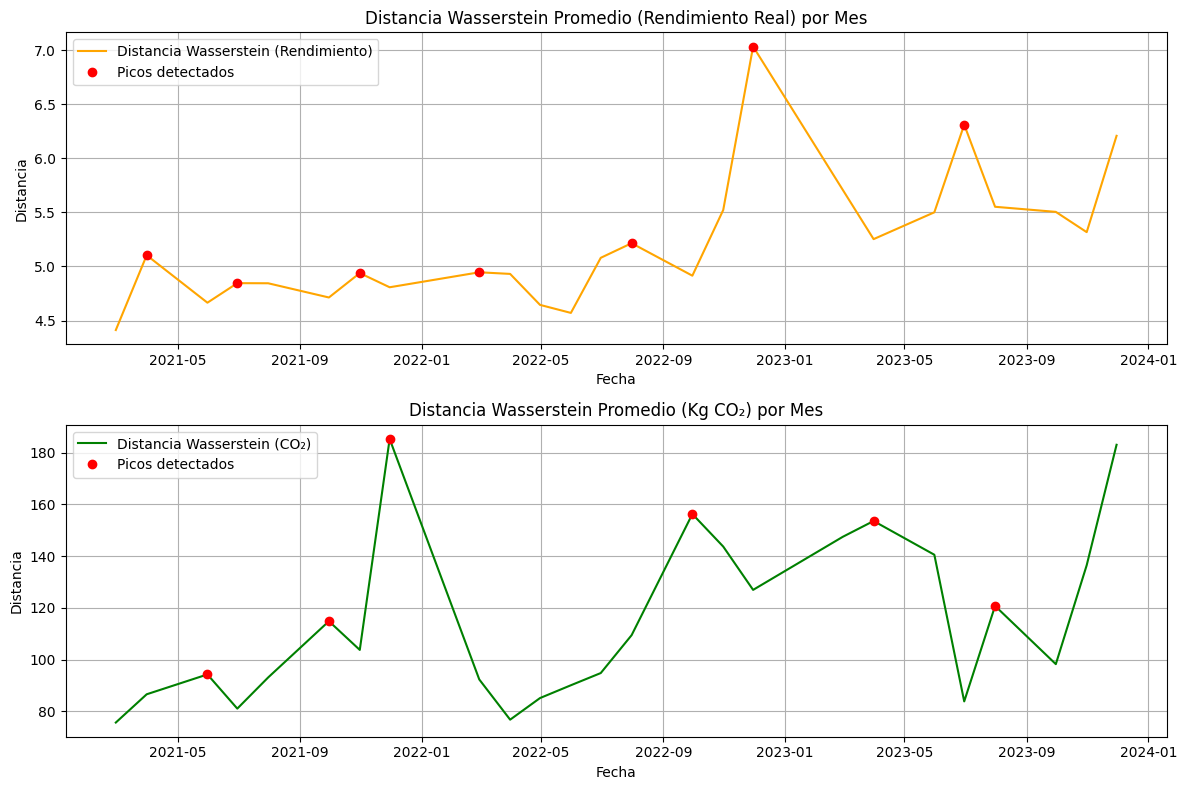

In [98]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# Detectar picos para rendimiento real
distancias1 = df_wasserstein_mensual["Distancia"]
picos1, _ = find_peaks(distancias1, prominence=0.01)

# Detectar picos para CO2
distancias2 = df_wasserstein_mensual2["Distancia4"]
picos2, _ = find_peaks(distancias2, prominence=0.01)

# Crear subplots
plt.figure(figsize=(12, 8))

# Subplot 1: Rendimiento real
plt.subplot(2, 1, 1)
plt.plot(distancias1.index, distancias1, label="Distancia Wasserstein (Rendimiento)", color="orange")
plt.plot(distancias1.index[picos1], distancias1.iloc[picos1], "ro", label="Picos detectados")
plt.title("Distancia Wasserstein Promedio (Rendimiento Real) por Mes")
plt.xlabel("Fecha")
plt.ylabel("Distancia")
plt.grid(True)
plt.legend()

# Subplot 2: Kg CO2
plt.subplot(2, 1, 2)
plt.plot(distancias2.index, distancias2, label="Distancia Wasserstein (CO₂)", color="green")
plt.plot(distancias2.index[picos2], distancias2.iloc[picos2], "ro", label="Picos detectados")
plt.title("Distancia Wasserstein Promedio (Kg CO₂) por Mes")
plt.xlabel("Fecha")
plt.ylabel("Distancia")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


Analisis previo

In [18]:
# Selección final de columnas relevantes
columnas_finales = [
    "recorrido",
    "precio_unitario",
    "cantidad_mercancía",
    "rendimiento",
    "rendimiento_real"
]

# Preparar df_mapper 
df_mapper = df_filtrado[columnas_finales].dropna().copy()

# Escalamiento
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_mapper)

In [159]:
# Inicializar Mapper
mapper = km.KeplerMapper()

# Proyección con PCA
#projected_data = mapper.fit_transform(X_scaled, projection=umap.UMAP(n_components=2))

In [161]:
def density_filter_cosine(X_scaled, epsilon):

  cosine_sim = cosine_similarity(X_scaled)

  f_eps = np.exp(-cosine_sim ** 2 / epsilon).sum(axis=1)
  f_eps /= np.sum(f_eps)


  scaler = MinMaxScaler(feature_range=(0, 1))
  f_eps = scaler.fit_transform(f_eps.reshape(-1, 1))

  return f_eps

In [162]:
# lens = density_filter_cosine(X_scaled,1)
# df_lens = pd.DataFrame(lens)
# df_lens.to_csv('lens.csv', index=False, encoding='utf-8-sig')
df_lens = pd.read_csv('lens.csv')
lens = df_lens.to_numpy()

In [163]:
# Crear el grafo usando una cobertura de 10 cubos con 30% de traslape
graph = mapper.map(lens,
                   X_scaled,
                   cover=km.Cover(n_cubes=10, perc_overlap=0.5),
                   clusterer=DBSCAN(eps=0.5, min_samples=5)
                   )

In [ ]:
# Crear visualización con múltiples variables como color
mapper.visualize(
    graph,
    path_html="mapper_output.html",
    title="Mapper de Consumo de Combustible SLB",
    custom_tooltips=df_mapper.index.astype(str),
    color_values=df_mapper[[
        "rendimiento_real",
        "rendimiento",
        "precio_unitario",
        "recorrido",
        "cantidad_mercancía"
    ]],
    color_function_name=[
        "Rendimiento Real",
        "Rendimiento Esperado",
        "Precio por Litro",
        "KM Recorridos",
        "Litros Cargados",
    ],
    node_color_function=np.array(["average", "std", "sum", "max", "min"])
)


'<!DOCTYPE html>\n<html>\n\n<head>\n  <meta charset="utf-8">\n  <meta name="generator" content="KeplerMapper">\n  <title>Mapper de Consumo de Combustible SLB | KeplerMapper</title>\n\n  <link rel="icon" type="image/png" href="http://i.imgur.com/axOG6GJ.jpg" />\n\n  <link href=\'https://fonts.googleapis.com/css?family=Roboto+Mono:700,300\' rel=\'stylesheet\' type=\'text/css\'>\n  <style>* {\n  margin: 0;\n  padding: 0;\n}\n\nhtml, body {\n  height: 100%;\n}\n\nbody {\n  font-family: "Roboto Mono", "Helvetica", sans-serif;\n  font-size: 14px;\n}\n\n#logo {\n  width:  85px;\n  height: 85px;\n}\n\n#display {\n  color: #95A5A6;\n  background: #212121;\n}\n\n#header {\n  background: #111111;\n}\n\n#print {\n  color: #000;\n  background: #FFF;\n}\n\nh1 {\n  font-size: 21px;\n  font-weight: 300;\n  font-weight: 300;\n}\n\nh2 {\n  font-size: 18px;\n  padding-bottom: 20px;\n  font-weight: 300;\n}\n\nh3 {\n  font-size: 14px;\n  font-weight: 700;\n  text-transform: uppercase;\n}\n\nh4 {\n  font-si

In [165]:
manual_indices = [35954, 35957, 35980, 35987, 36028]
columnas_deseadas=['rendimiento','rendimiento_real','precio_unitario','cantidad_mercancía','kg_c02','Unidad']

In [166]:
# indices_cluster = índices relativos a df_mapper
indices_cluster = graph['nodes']['cube2_cluster10']

# Obtener los índices originales 
indices_originales = df_mapper.index[indices_cluster]

df_original = df_filtrado.loc[indices_originales, columnas_deseadas]

df_manual = df_filtrado.loc[manual_indices, columnas_deseadas]

# Ordenar por índice
df1 = df_manual.sort_index()
df2 = df_original.sort_index()

In [167]:
df_mapper_index = {}

for node_name, indices in graph["nodes"].items():
    df_mapper_index[node_name] = df_filtrado.index[indices].tolist()

In [168]:
joblib.dump(df_mapper_index, 'df_mapper_index.pkl')

['df_mapper_index.pkl']

In [169]:
# Obtener índices absolutos desde df_filtrado
indices_abs1 = df_mapper.index[graph["nodes"]["cube6_cluster3"]]
indices_abs2 = df_mapper.index[graph["nodes"]["cube5_cluster5"]]
indices_abs3 = df_mapper.index[graph["nodes"]["cube4_cluster8"]]
indices_abs4 = df_mapper.index[graph["nodes"]["cube5_cluster7"]]
indices_abs5 = df_mapper.index[graph["nodes"]["cube3_cluster11"]]
indices_abs6 = df_mapper.index[graph["nodes"]["cube2_cluster9"]]
indices_abs7 = df_mapper.index[graph["nodes"]["cube2_cluster8"]]
indices_abs8 = df_mapper.index[graph["nodes"]["cube3_cluster10"]]
indices_abs9 = df_mapper.index[graph["nodes"]["cube4_cluster10"]]
indices_abs10 = df_mapper.index[graph["nodes"]["cube6_cluster4"]]
indices_abs11 = df_mapper.index[graph["nodes"]["cube2_cluster10"]]
indices_abs12 = df_mapper.index[graph["nodes"]["cube3_cluster13"]]
indices_abs13 = df_mapper.index[graph["nodes"]["cube4_cluster9"]]
indices_abs14 = df_mapper.index[graph["nodes"]["cube5_cluster8"]]
# Seleccionar directamente desde df_filtrado
ej1=df_filtrado.loc[indices_abs1, columnas_deseadas]
ej2=df_filtrado.loc[indices_abs2, columnas_deseadas]
ej3=df_filtrado.loc[indices_abs3, columnas_deseadas]
ej4=df_filtrado.loc[indices_abs4, columnas_deseadas]
ej5=df_filtrado.loc[indices_abs5, columnas_deseadas]
ej6=df_filtrado.loc[indices_abs6, columnas_deseadas]
ej7=df_filtrado.loc[indices_abs7, columnas_deseadas]
ej8=df_filtrado.loc[indices_abs8, columnas_deseadas]
ej9=df_filtrado.loc[indices_abs9, columnas_deseadas]
ej10=df_filtrado.loc[indices_abs10, columnas_deseadas]
ej11=df_filtrado.loc[indices_abs11, columnas_deseadas]
ej12=df_filtrado.loc[indices_abs12, columnas_deseadas]
ej13=df_filtrado.loc[indices_abs13, columnas_deseadas]
ej14=df_filtrado.loc[indices_abs14, columnas_deseadas]

df_mal_rendimiento = pd.concat([ej1, ej2, ej3, ej4, ej5, ej6, ej7, ej8, ej9, ej10, ej11, ej12, ej13, ej14])
df_mal_rendimiento = df_mal_rendimiento.rename(columns={
    "rendimiento": "rendimiento_real",
    "rendimiento_real": "rendimiento_esperado"
})
df_mal_rendimiento.head()

,rendimiento_real,rendimiento_esperado,precio_unitario,cantidad_mercancía,kg_c02,Unidad
24575,22.69,14.0,24.24,154.17,160.430888,UNIDADVF634
24583,23.99,14.0,24.24,208.42,214.680888,UNIDAD1NKDL
24617,23.79,14.0,24.24,168.00,174.260888,UNIDAD1HTWA
24620,23.40,14.0,24.24,170.00,176.260888,UNIDAD3WKDD
24640,23.79,14.0,24.24,210.17,216.430888,UNIDAD1NKDL


In [170]:
df_filtrado.to_csv('df_filtrado.csv', index=False, encoding='utf-8-sig')

In [171]:
# Verifica si hay entradas duplicadas por índice
duplicados = df_mal_rendimiento.index.duplicated(keep=False)

# Mostrar cuántas filas están repetidas
print(f"Número de filas duplicadas: {duplicados.sum()}")

print("Índices duplicados:")
print(df_mal_rendimiento.index[duplicados].unique())

df_mal_rendimiento_sin_duplicados = df_mal_rendimiento[~df_mal_rendimiento.index.duplicated(keep='first')]

Número de filas duplicadas: 580
Índices duplicados:
Index([24575, 24583, 24617, 24620, 24640, 24652, 24653, 24655, 24656, 24688,
       ...
       24619, 24637, 24677, 24695, 24706, 24720, 24905, 24940, 24946, 24948],
      dtype='int64', length=290)


In [172]:
indices_originales = df_mal_rendimiento_sin_duplicados.index
df_malos_contexto = df_filtrado.loc[indices_originales].copy()

In [173]:
df_malos_contexto[["rendimiento","rendimiento_real"]]   

,rendimiento,rendimiento_real
24575,22.69,14.0
24583,23.99,14.0
24617,23.79,14.0
24620,23.40,14.0
24640,23.79,14.0
...,...,...
24878,23.79,14.0
24905,23.55,14.0
24940,23.99,14.0
24946,23.79,14.0


In [174]:
vehiculos_wf0c = df_filtrado[df_filtrado["vehículo"].str.startswith("Unidad WF0C", na=False)]
print(vehiculos_wf0c[["vehículo", "Unidad"]])

                             vehículo       Unidad
7            Unidad WF0CP6A76H1C07201  UNIDADWF0CP
11           Unidad WF0CP6A71J1C54318  UNIDADWF0CP
33           Unidad WF0CP6A71J1C54318  UNIDADWF0CP
49           Unidad WF0CP6A75J1C82381  UNIDADWF0CP
54           Unidad WF0CP6A73J1C57575  UNIDADWF0CP
...                               ...          ...
39815        Unidad WF0CP6A71K1D32713  UNIDADWF0CP
39818  Unidad WF0CP6A70K1D43993        UNIDADWF0CP
39821  Unidad WF0CP6A74K1D33340        UNIDADWF0CP
39827        Unidad WF0CP6A71K1D32713  UNIDADWF0CP
39828        Unidad WF0CP6A71K1D32713  UNIDADWF0CP

[4548 rows x 2 columns]


In [175]:
# Top 5 vehículos más repetidos
print(df_malos_contexto["vehículo"].value_counts().head(10))

# Top 5 Unidades más repetidas
print(df_malos_contexto["Unidad"].value_counts().head(5))

vehículo
Unidad 1FBAX2CM5KKA33680          15
Unidad 1FBAX2CM3KKA33676          13
Unidad WF0CP6A77H1C08597          13
Unidad 3HAMMAAR19L121527          11
Unidad WF0CP6A73J1C84999          11
Unidad WF0CP6A73J1C54353          11
Unidad 1FTMF1CM8DKF62856          10
Unidad 1FTMF1C81GKD98776          10
Unidad 1FTEW1CB7MKD18909          10
Unidad WF0CP6A75K1D03523           8
Name: count, dtype: int64
Unidad
UNIDADWF0CP    73
UNIDAD1FBAX    49
UNIDAD1FTMF    36
UNIDAD1FTEW    24
UNIDADWF06S    19
Name: count, dtype: int64


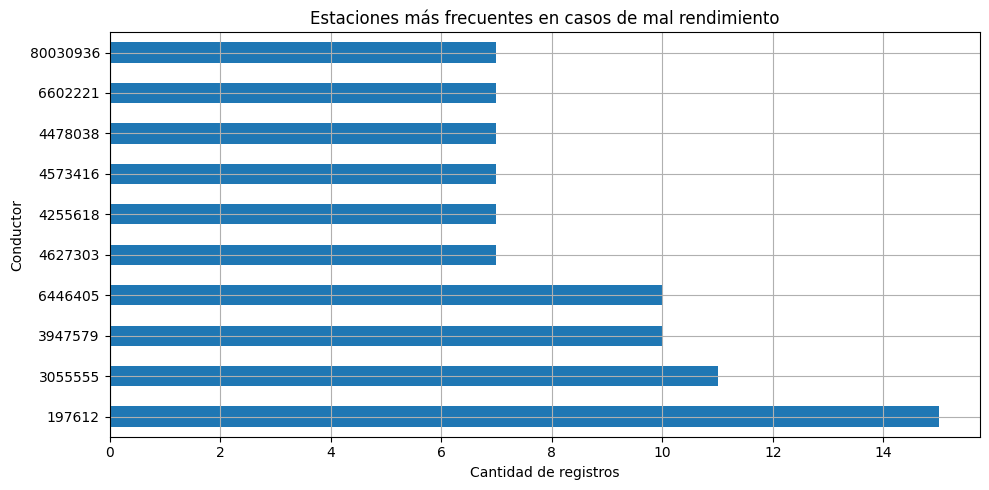

In [ ]:
plt.figure(figsize=(10,5))
df_malos_contexto["conductor"].value_counts().head(10).plot(kind="barh")
plt.title("Estaciones más frecuentes en casos de mal rendimiento")
plt.xlabel("Cantidad de registros")
plt.ylabel("Conductor")
plt.grid(True)
plt.tight_layout()


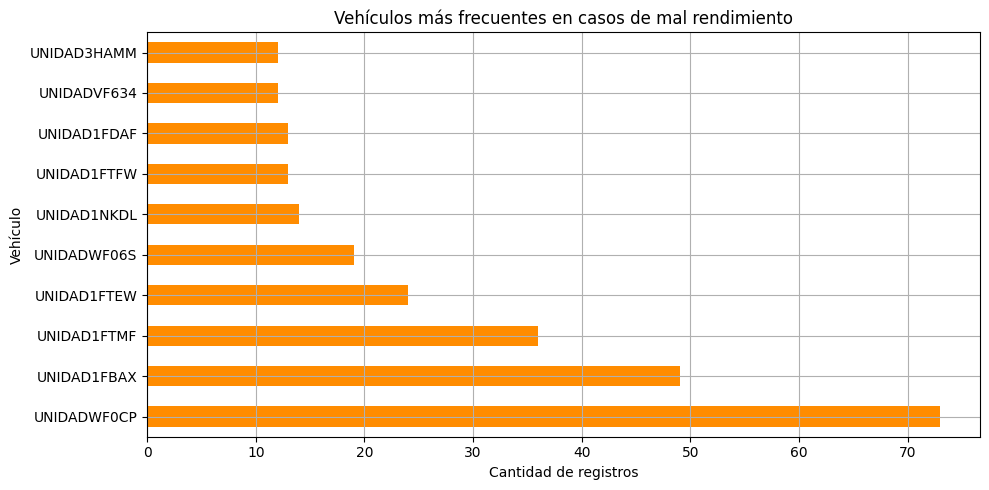

In [177]:
plt.figure(figsize=(10,5))
df_malos_contexto["Unidad"].value_counts().head(10).plot(kind="barh", color="darkorange")
plt.title("Vehículos más frecuentes en casos de mal rendimiento")
plt.xlabel("Cantidad de registros")
plt.ylabel("Vehículo")
plt.grid(True)
plt.tight_layout()


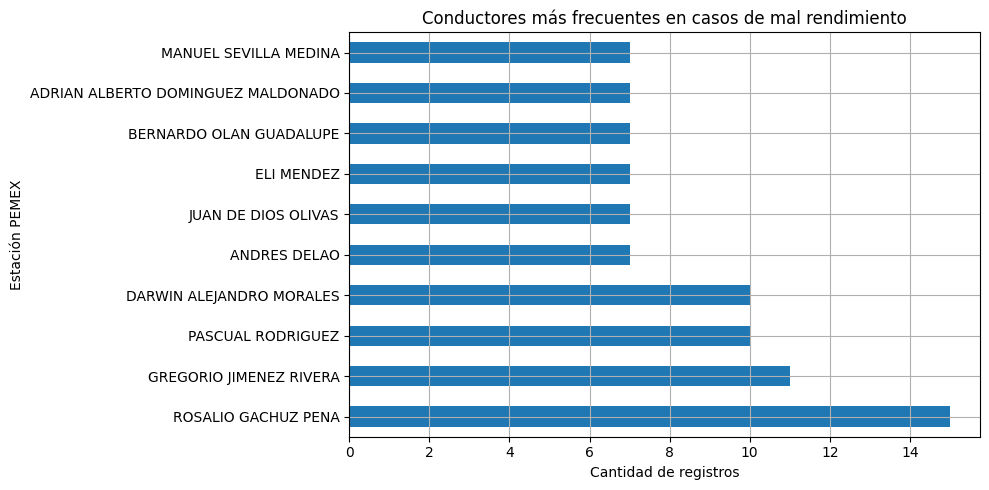

In [178]:
plt.figure(figsize=(10,5))
df_malos_contexto["no_estación_pemex"].value_counts().head(10).plot(kind="barh")
plt.title("Conductores más frecuentes en casos de mal rendimiento")
plt.xlabel("Cantidad de registros")
plt.ylabel("Estación PEMEX")
plt.grid(True)
plt.tight_layout()


## Modelo Predictivo de Clasificacion

In [179]:
# Crear df_modelo desde df_filtrado
df_modelo = df_filtrado.copy()

# Asegurar columnas numéricas
df_modelo["rendimiento"] = pd.to_numeric(df_modelo["rendimiento"], errors="coerce")
df_modelo["rendimiento_real"] = pd.to_numeric(df_modelo["rendimiento_real"], errors="coerce")

# Calcular eficiencia relativa y binaria
df_modelo["eficiencia_relativa"] = df_modelo["rendimiento_real"] / df_modelo["rendimiento"]
df_modelo["eficiencia_ok"] = (df_modelo["eficiencia_relativa"] >= 0.6).astype(int)

# Codificación estadística
df_modelo["conductor_score"] = df_modelo.groupby("conductor")["eficiencia_ok"].transform("mean")
df_modelo["vehiculo_score"] = df_modelo.groupby("vehículo")["eficiencia_ok"].transform("mean")

# Rendimiento promedio real por conductor y vehículo
df_modelo["rend_cond_mean"] = df_modelo.groupby("conductor")["rendimiento_real"].transform("mean")
df_modelo["rend_veh_mean"] = df_modelo.groupby("vehículo")["rendimiento_real"].transform("mean")

In [ ]:
# 1. Definir variables
num_cols = [
    'conductor_score', 'vehiculo_score',
    'rend_cond_mean', 'rend_veh_mean'
]

cat_cols = ['division', 'bl', 'mercancía', 'no_estación_pemex']

# Categóricas estén en formato string
for col in cat_cols:
    df_modelo[col] = df_modelo[col].astype(str)

# 2. Separar X e y
X = df_modelo[num_cols + cat_cols]
y = df_modelo["eficiencia_ok"].astype(int)

# 3. Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

# 4. Preprocesamiento: OneHot para categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='passthrough'  
)

# 5. Definir pipeline
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ))
])

# Pipeline ya definido: clf
param_grid = {
    'classifier__n_estimators': [100, 300, 500],
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__gamma': [0, 0.1, 0.3],
    'classifier__min_child_weight': [1, 3, 5]
}

# Tuning con 3-fold CV, ajustado a F1-score
search = RandomizedSearchCV(
    clf,
    param_distributions=param_grid,
    n_iter=30,
    cv=3,
    scoring='f1',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)

# Ver los mejores parámetros encontrados
print("🎯 Mejores parámetros encontrados:")
print(search.best_params_)

# Evaluar el mejor modelo en el test set
y_pred = search.predict(X_test)
print("\n📋 Reporte de clasificación con mejores hiperparámetros:")
print(classification_report(y_test, y_pred))


# 6. Entrenar
clf.fit(X_train, y_train)

# 7. Predecir
y_pred = clf.predict(X_test)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


c:\Users\srcsa\OneDrive\Escritorio\VSC\Topo\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:32:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🎯 Mejores parámetros encontrados:
{'classifier__subsample': 1.0, 'classifier__n_estimators': 500, 'classifier__min_child_weight': 1, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.1, 'classifier__gamma': 0.1, 'classifier__colsample_bytree': 1.0}

📋 Reporte de clasificación con mejores hiperparámetros:
              precision    recall  f1-score   support

           0       0.87      0.92      0.90      6181
           1       0.76      0.65      0.70      2375

    accuracy                           0.85      8556
   macro avg       0.82      0.78      0.80      8556
weighted avg       0.84      0.85      0.84      8556



c:\Users\srcsa\OneDrive\Escritorio\VSC\Topo\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:32:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


📋 Reporte de clasificación:

              precision    recall  f1-score   support

           0       0.87      0.92      0.90      6181
           1       0.77      0.65      0.70      2375

    accuracy                           0.85      8556
   macro avg       0.82      0.79      0.80      8556
weighted avg       0.84      0.85      0.84      8556



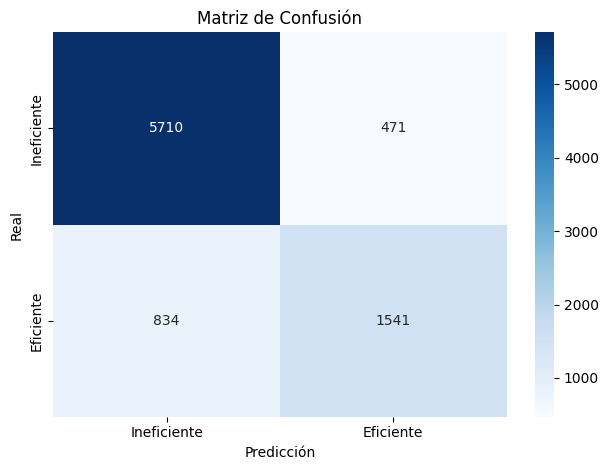

In [181]:
# 8. Evaluación
print("📋 Reporte de clasificación:\n")
print(classification_report(y_test, y_pred))

# 9. Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Ineficiente", "Eficiente"],
            yticklabels=["Ineficiente", "Eficiente"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.show()

In [182]:
def predecir_eficiencia(conductor, vehiculo, division, bl, mercancia, estacion, modelo, df_base):

    # Validaciones
    if conductor not in df_base['conductor'].values:
        raise ValueError(f"Conductor '{conductor}' no encontrado en el historial.")
    if vehiculo not in df_base['vehículo'].values:
        raise ValueError(f"Vehículo '{vehiculo}' no encontrado en el historial.")
    if division not in df_base['division'].astype(str).values:
        raise ValueError(f"División '{division}' no reconocida.")
    if bl not in df_base['bl'].astype(str).values:
        raise ValueError(f"BL '{bl}' no reconocido.")
    if mercancia not in df_base['mercancía'].astype(str).values:
        raise ValueError(f"Mercancía '{mercancia}' no reconocida.")
    if estacion not in df_base['no_estación_pemex'].astype(str).values:
        raise ValueError(f"Estación Pemex '{estacion}' no encontrada.")

    # Cálculo de features desde historial
    conductor_score = df_base[df_base['conductor'] == conductor]["eficiencia_ok"].mean()
    vehiculo_score = df_base[df_base['vehículo'] == vehiculo]["eficiencia_ok"].mean()
    rend_cond_mean = df_base[df_base['conductor'] == conductor]["rendimiento_real"].mean()
    rend_veh_mean = df_base[df_base['vehículo'] == vehiculo]["rendimiento_real"].mean()

    # Construir input
    df_input = pd.DataFrame([{
        'conductor_score': conductor_score,
        'vehiculo_score': vehiculo_score,
        'rend_cond_mean': rend_cond_mean,
        'rend_veh_mean': rend_veh_mean,
        'division': division,
        'bl': bl,
        'mercancía': mercancia,
        'no_estación_pemex': estacion
    }])

    # Convertir categóricas a string
    for col in ['division', 'bl', 'mercancía', 'no_estación_pemex']:
        df_input[col] = df_input[col].astype(str)

    # Predicción
    pred = modelo.predict(df_input)[0]
    proba = modelo.predict_proba(df_input)[0][1]

    resultado = "EFICIENTE ✅" if pred == 1 else "INEFICIENTE ❌"
    print(f"\nPredicción para:")
    print(f"→ Conductor: {conductor}")
    print(f"→ Vehículo: {vehiculo}")
    print(f"→ Resultado: {resultado}")
    print(f"→ Probabilidad de eficiencia: {proba:.2%}")


In [183]:
predecir_eficiencia(
    conductor="ROSALIO GACHUZ PENA",
    vehiculo="Unidad 1HTWAAAR29J066490",
    division="RPF",
    bl="RPI",
    mercancia="DIESEL",
    estacion="9361",
    modelo=clf,
    df_base=df_modelo
)



Predicción para:
→ Conductor: ROSALIO GACHUZ PENA
→ Vehículo: Unidad 1HTWAAAR29J066490
→ Resultado: INEFICIENTE ❌
→ Probabilidad de eficiencia: 0.91%


In [184]:
predecir_eficiencia(
    conductor="ANDRES DELAO",
    vehiculo="Unidad 1FTFW1CD4PFA98888",
    division="RPF",
    bl="RPS",
    mercancia="G SUPER",
    estacion="1",
    modelo=clf,
    df_base=df_modelo
)



Predicción para:
→ Conductor: ANDRES DELAO
→ Vehículo: Unidad 1FTFW1CD4PFA98888
→ Resultado: EFICIENTE ✅
→ Probabilidad de eficiencia: 95.45%
